# <center> An Introduction to Deep Learning With Python <center/>

### [5.3] Using a pretrained convnet
Prof. Yuzo Iano

pgs: 143 - 158

#### Instantiating the VGG16 convolutional base

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
bloc

#### Extracting features using the pretrained convolutional base

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '../CAP_5/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [3]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

#### Defining and training the densely connected classifier

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6150 - acc: 0.6705 - val_loss: 0.4784 - val_acc: 0.7820
Epoch 2/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.4401 - acc: 0.8015 - val_loss: 0.3699 - val_acc: 0.8600
Epoch 3/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3712 - acc: 0.8405 - val_loss: 0.3285 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3263 - acc: 0.8660 - val_loss: 0.3045 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2912 - acc: 0.8885 - val_loss: 0.2866 - val_acc: 0.8930
Epoch 6/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2659 - acc: 0.8970 - val_loss: 0.2792 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 3s 1ms/step - loss: 0.2523 - acc: 0.8975 - v

#### Plotting the results

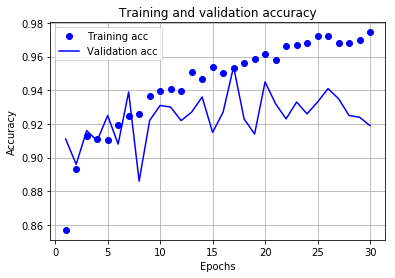

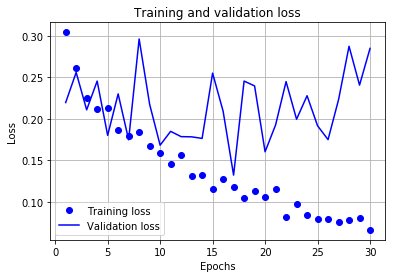

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

#### Adding a densely connected classifier on top of the convolutional base

In [8]:
from keras.layers import Flatten

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
print('This is the number of trainable weights before freezing the conv base: ', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base:  30


In [10]:
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base: ', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base:  4


#### Training the model end to end with a frozen convolutional base

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 308s 3s/step - loss: 0.5994 - acc: 0.6860 - val_loss: 0.4581 - val_acc: 0.8320
Epoch 2/30
100/100 [==============================] - 307s 3s/step - loss: 0.5016 - acc: 0.7815 - val_loss: 0.3908 - val_acc: 0.8490
Epoch 3/30
100/100 [==============================] - 306s 3s/step - loss: 0.4370 - acc: 0.8240 - val_loss: 0.3407 - val_acc: 0.8700
Epoch 4/30
100/100 [==============================] - 308s 3s/step - loss: 0.4007 - acc: 0.8195 - val_loss: 0.3150 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 305s 3s/step - loss: 0.3875 - acc: 0.8330 - val_loss: 0.2976 - val_acc: 0.8800
Epoch 6/30
100/100 [==============================] - 305s 3s/step - loss: 0.3818 - acc: 0.8255 - val_loss: 0.2861 - val_acc: 0.8870
Epoch 7/30
100/100 [==============================] - 309s 3s/step - loss: 0.3676 - acc: 0.8425 - val_loss: 0.2909 - val_acc: 0.8780
Epoch 8/30
100/100 [==============================] - 305s 3s/step - 

#### Plotting the results

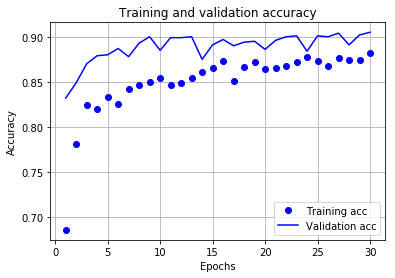

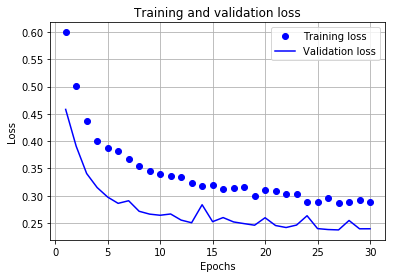

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [14]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### Freezing all layers up to a specific one

In [15]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#### Fine-tuning the model

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/30
100/100 [==============================] - 356s 4s/step - loss: 0.3044 - acc: 0.8570 - val_loss: 0.2197 - val_acc: 0.9110
Epoch 2/30
100/100 [==============================] - 356s 4s/step - loss: 0.2608 - acc: 0.8935 - val_loss: 0.2561 - val_acc: 0.8960
Epoch 3/30
100/100 [==============================] - 355s 4s/step - loss: 0.2253 - acc: 0.9130 - val_loss: 0.2110 - val_acc: 0.9160
Epoch 4/30
100/100 [==============================] - 355s 4s/step - loss: 0.2120 - acc: 0.9110 - val_loss: 0.2456 - val_acc: 0.9100
Epoch 5/30
100/100 [==============================] - 356s 4s/step - loss: 0.2135 - acc: 0.9105 - val_loss: 0.1803 - val_acc: 0.9250
Epoch 6/30
100/100 [==============================] - 355s 4s/step - loss: 0.1866 - acc: 0.9195 - val_loss: 0.2302 - val_acc: 0.9080
Epoch 7/30
100/100 [==============================] - 357s 4s/step - loss: 0.1800 - acc: 0.9250 - val_loss: 0.1749 - val_acc: 0.9390
Epoch 8/30
100/100 [==============================] - 358s 4s/step - 

#### Plotting the results

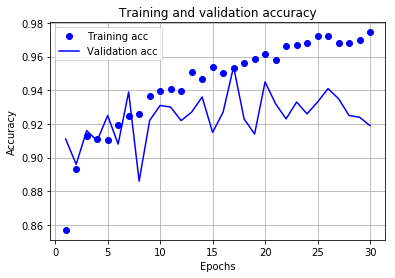

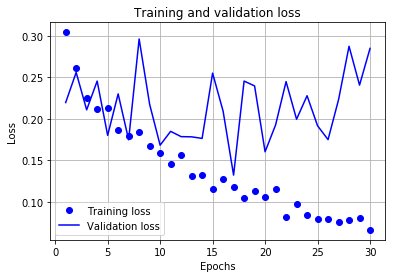

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

#### Smoothing the plots

In [18]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

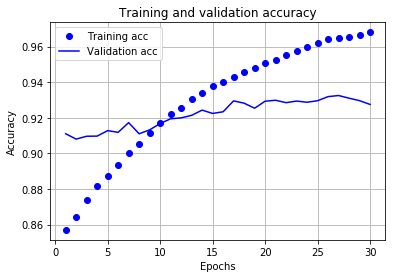

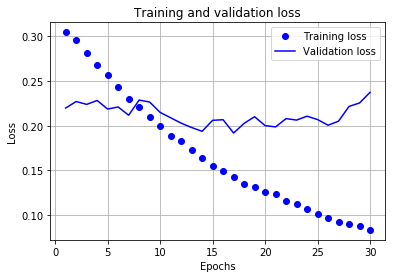

In [19]:
plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [20]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Test acc: ', test_acc)

Found 1000 images belonging to 2 classes.
Test acc:  0.9249999916553497


###### Pablo Minango
* pablodavid218@gmail.com 